<a href="https://colab.research.google.com/github/Wild-Manish/Glasses-Segmentation/blob/main/Image_masking_and_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [36]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [37]:
using_colab = True

In [38]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    #get images from my git repo and upload them to a new directory: images
    !mkdir images
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_01.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_02.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_03.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_04.jpeg?raw=true
    !wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_05.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_06.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_07.jpeg?raw=true
    #!wget -P images https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_08.jpeg?raw=true

    #get sam model
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0l3ru6p2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0l3ru6p2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
mkdir: cannot create directory ‘images’: File exists
--2024-03-31 20:24:44--  https://github.com/Wild-Manish/Glasses-Segmentation/blob/main/BTR4522C3_img_05.jpeg?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Wild-Manish/Glasses-Segmentation/raw/main/BTR4522C3_img_05.jpeg [following]
--2024-03-31 20:24:44--  https://github.com/Wild-Manish/Glasses-Segm

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [39]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [40]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Example image

In [41]:
image = cv2.imread('/content/images/BTR4522C3_img_05.jpeg?raw=true')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

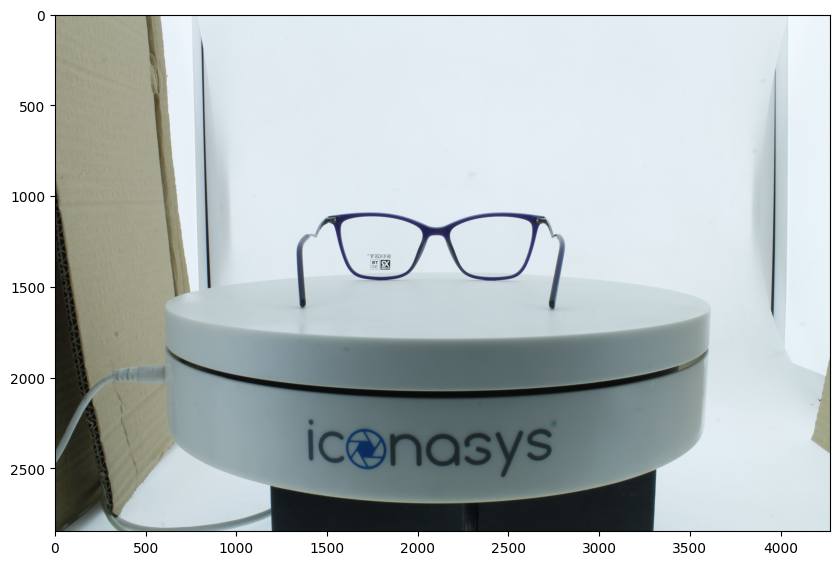

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [43]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = torch.device('cpu')

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [44]:
#predictor.set_image(image1)
#predictor.set_image(image2)
predictor.set_image(image)
#predictor.set_image(image4)

To select the truck, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [45]:
input_point = np.array([[1800, 1250]])
input_label = np.array([1])

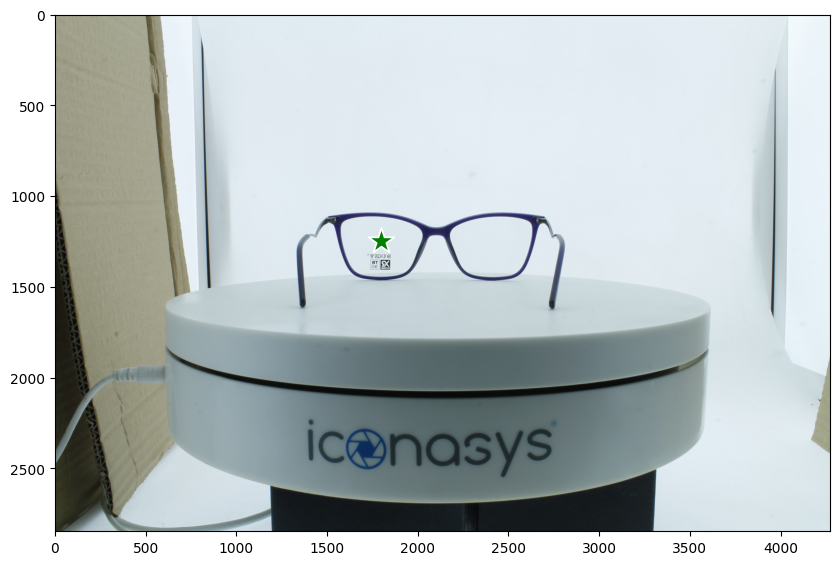

In [46]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [47]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [48]:
masks.shape  # (number_of_masks) x H x W

(3, 2848, 4272)

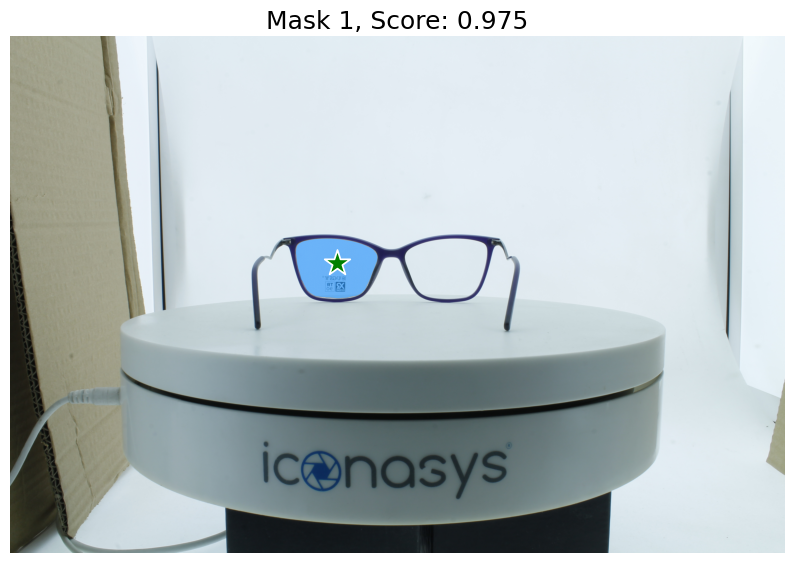

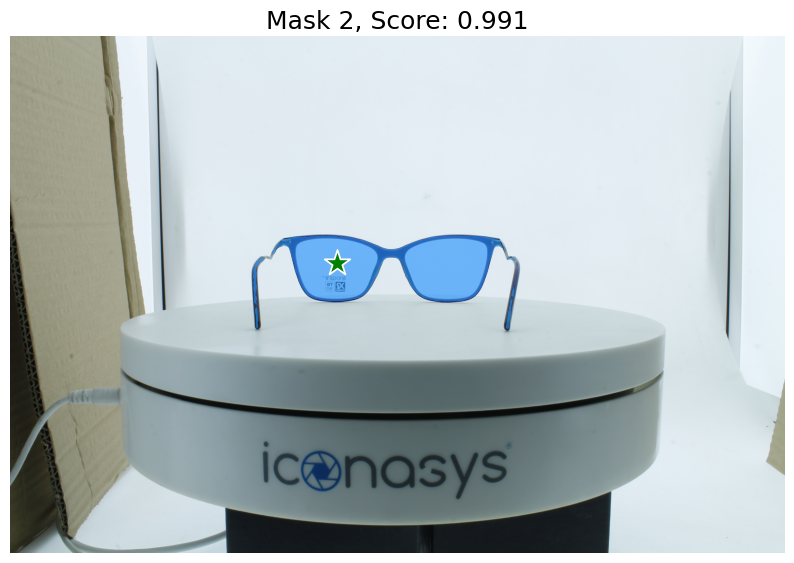

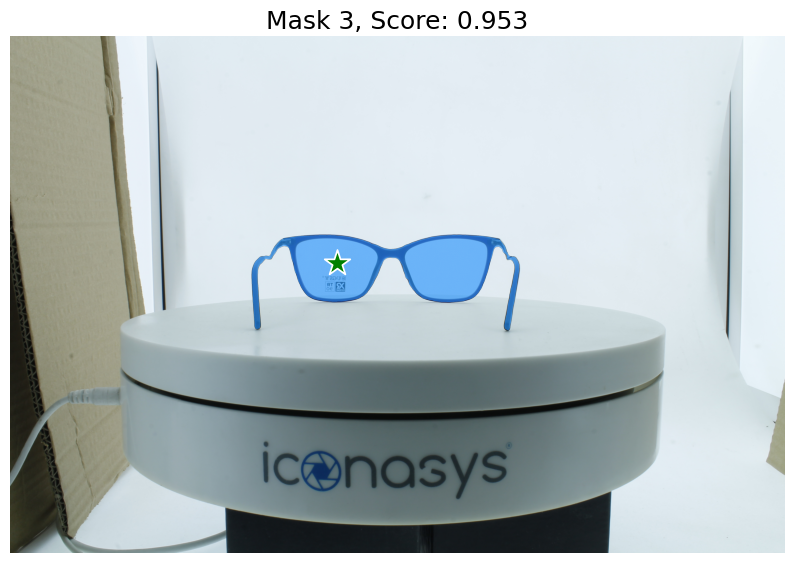

In [49]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [50]:
input_point = np.array([[1730, 1200], [1700, 1200], [2000, 1300]])
input_label = np.array([1, 1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [51]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [52]:
masks.shape

(1, 2848, 4272)

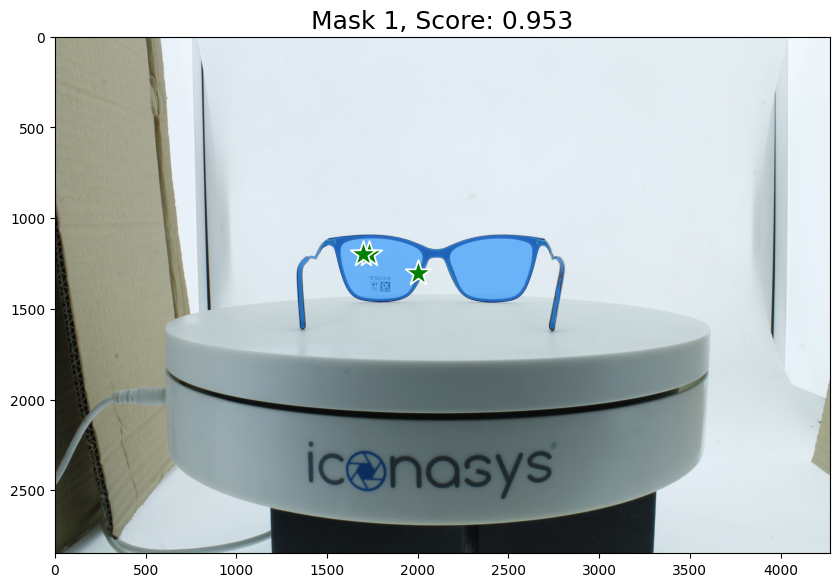

In [53]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.title(f"Mask {1}, Score: {score:.3f}", fontsize=18)
plt.show()

In [54]:
input_point = np.array([[1730, 1200], [1700, 1200], [2000, 1300], [1000, 1700], [1500, 2000], [3000,1800]])
input_label = np.array([1, 1, 1, 0, 0, 0])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [55]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

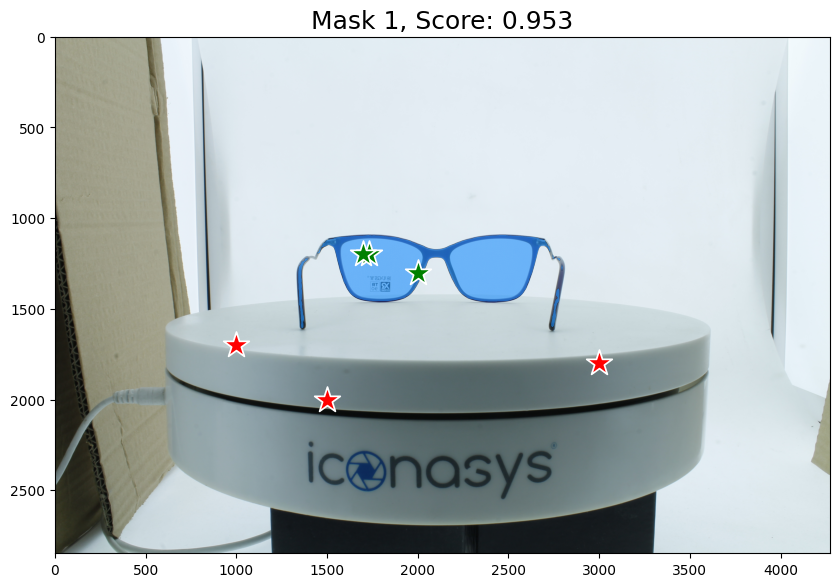

In [56]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.title(f"Mask {1}, Score: {score:.3f}", fontsize=18)
plt.show()

## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [57]:
input_box = np.array([800, 800, 3300, 1700])

In [58]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

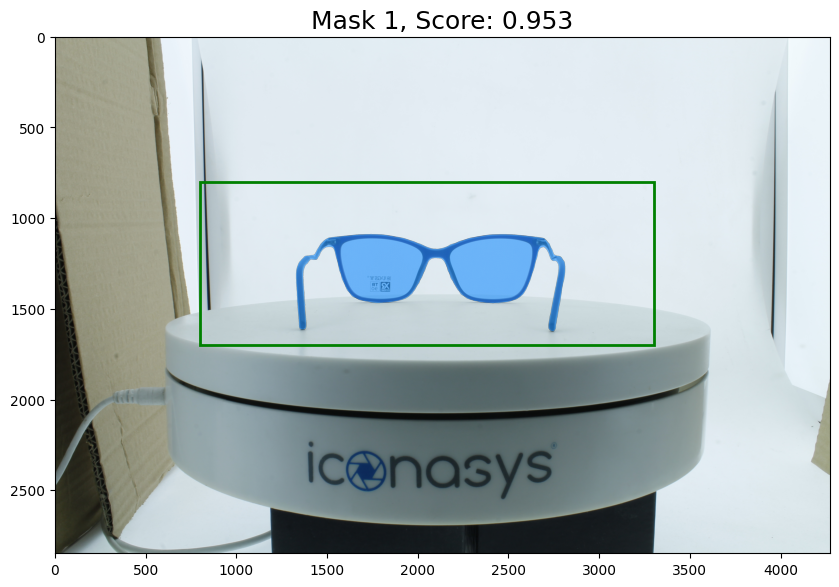

In [59]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('on')
plt.title(f"Mask {1}, Score: {score:.3f}", fontsize=18)
plt.show()

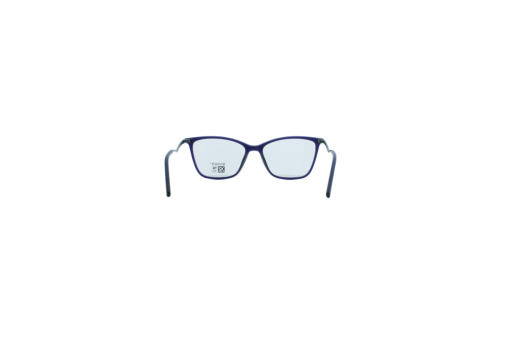

In [60]:
segmentation_mask = masks[0]
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)
white_background = np.ones_like(image)*255
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()